In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# --- File paths ---
s2_path = "Phoenix_S2_2022_2025.tif"
label_path = "Phoenix_Central_DW_2022_2025.tif"

# --- Load Sentinel-2 image (4 bands: B2, B3, B4, B8) ---
with rasterio.open(s2_path) as src:
    s2_image = src.read()  # shape: (bands, height, width)
    s2_meta = src.meta
    print("Sentinel-2 shape:", s2_image.shape)

# --- Load land cover labels (single band) ---
with rasterio.open(label_path) as src:
    label_image = src.read(1)
    label_meta = src.meta
    print("Label shape:", label_image.shape)


Sentinel-2 shape: (4, 2785, 2784)
Label shape: (2785, 2784)


In [2]:
# --- Normalize Sentinel-2 image ---
s2_image = s2_image.astype(np.float32)

# Handle missing values
s2_image = np.nan_to_num(s2_image, nan=0.0)

# Sentinel-2 reflectance is typically scaled by 10,000
s2_image = s2_image / 10000.0

# Clip values to [0, 1]
s2_image = np.clip(s2_image, 0, 1)

# Check min/max for sanity
for i in range(s2_image.shape[0]):
    print(f"Band {i+1}: min={s2_image[i].min():.4f}, max={s2_image[i].max():.4f}")


Band 1: min=0.0000, max=0.9886
Band 2: min=0.0000, max=0.9374
Band 3: min=0.0000, max=1.0000
Band 4: min=0.0000, max=1.0000


In [3]:
from skimage.util import view_as_windows

PATCH_SIZE = 256

# Transpose Sentinel-2 to shape: (H, W, C)
X_full = s2_image.transpose(1, 2, 0)  # (2785, 2784, 4)

# --- Create image patches ---
X_patches = view_as_windows(X_full, (PATCH_SIZE, PATCH_SIZE, 4), step=PATCH_SIZE)
X_patches = X_patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 4)

# --- Create label patches ---
Y_patches = view_as_windows(label_image, (PATCH_SIZE, PATCH_SIZE), step=PATCH_SIZE)
Y_patches = Y_patches.reshape(-1, PATCH_SIZE, PATCH_SIZE)

# --- Print shapes ---
print("X_patches:", X_patches.shape)
print("Y_patches:", Y_patches.shape)


X_patches: (100, 256, 256, 4)
Y_patches: (100, 256, 256)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_patches, Y_patches, test_size=0.2, random_state=42
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)


Training set: (80, 256, 256, 4) (80, 256, 256)
Validation set: (20, 256, 256, 4) (20, 256, 256)


In [5]:
import tensorflow as tf

NUM_CLASSES = 9

# Ensure labels are integer type
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

# One-hot encode
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)

print("y_train_cat shape:", y_train_cat.shape)
print("y_val_cat shape:", y_val_cat.shape)


y_train_cat shape: (80, 256, 256, 9)
y_val_cat shape: (20, 256, 256, 9)


In [6]:
from tensorflow.keras import layers, models

def build_unet(input_shape=(256, 256, 4), num_classes=9):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c7)

    model = models.Model(inputs, outputs)
    return model


In [7]:
model = build_unet()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,184 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 1,947,433 (7.43 MB)

 Trainable params: 1,947,433 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("unet_best_model.h5", save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=8,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.4413 - loss: 1.8941
Epoch 1: val_loss improved from inf to 0.65624, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4629 - loss: 1.8545 - val_accuracy: 0.8919 - val_loss: 0.6562 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.8658 - loss: 0.7034
Epoch 2: val_loss improved from 0.65624 to 0.51826, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8661 - loss: 0.6980 - val_accuracy: 0.8920 - val_loss: 0.5183 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.8616 - loss: 0.5718
Epoch 3: val_loss improved from 0.51826 to 0.46457, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8623 - loss: 0.5683 - val_accuracy: 0.8920 - val_loss: 0.4646 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.8760 - loss: 0.4732
Epoch 4: val_loss improved from 0.46457 to 0.41534, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8753 - loss: 0.4742 - val_accuracy: 0.8920 - val_loss: 0.4153 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.8661 - loss: 0.4750
Epoch 5: val_loss did not improve from 0.41534
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8663 - loss: 0.4756 - val_accuracy: 0.8920 - val_loss: 0.6080 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - accuracy: 0.8391 - loss: 0.6258
Epoch 6: val_loss improved from 0.41534 to 0.38935, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8418 - loss: 0.6151 - val_accuracy: 0.8920 - val_loss: 0.3894 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.8617 - loss: 0.4489
Epoch 7: val_loss improved from 0.38935 to 0.35194, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8623 - loss: 0.4456 - val_accuracy: 0.8920 - val_loss: 0.3519 - learning_rate: 0.0010
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.8531 - loss: 0.4325
Epoch 8: val_loss improved from 0.35194 to 0.33784, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8545 - loss: 0.4294 - val_accuracy: 0.8919 - val_loss: 0.3378 - learning_rate: 0.0010
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8871 - loss: 0.3480   
Epoch 9: val_loss improved from 0.33784 to 0.33218, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8854 - loss: 0.3509 - val_accuracy: 0.8918 - val_loss: 0.3322 - learning_rate: 0.0010
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8509 - loss: 0.4067
Epoch 10: val_loss improved from 0.33218 to 0.30737, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8524 - loss: 0.4029 - val_accuracy: 0.8919 - val_loss: 0.3074 - learning_rate: 0.0010
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8475 - loss: 0.3926 
Epoch 11: val_loss improved from 0.30737 to 0.28535, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8495 - loss: 0.3882 - val_accuracy: 0.8949 - val_loss: 0.2854 - learning_rate: 0.0010
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8881 - loss: 0.2942
Epoch 12: val_loss improved from 0.28535 to 0.28082, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8863 - loss: 0.2974 - val_accuracy: 0.8955 - val_loss: 0.2808 - learning_rate: 0.0010
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8739 - loss: 0.3148
Epoch 13: val_loss improved from 0.28082 to 0.24740, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8734 - loss: 0.3144 - val_accuracy: 0.8952 - val_loss: 0.2474 - learning_rate: 0.0010
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8767 - loss: 0.2981
Epoch 14: val_loss did not improve from 0.24740
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8764 - loss: 0.2984 - val_accuracy: 0.8913 - val_loss: 0.2570 - learning_rate: 0.0010
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.8882 - loss: 0.2648
Epoch 15: val_loss improved from 0.24740 to 0.23767, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8866 - loss: 0.2670 - val_accuracy: 0.8956 - val_loss: 0.2377 - learning_rate: 0.0010
Epoch 16/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - accuracy: 0.8838 - loss: 0.2504
Epoch 16: val_loss improved from 0.23767 to 0.22703, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8829 - loss: 0.2526 - val_accuracy: 0.8947 - val_loss: 0.2270 - learning_rate: 0.0010
Epoch 17/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.9183 - loss: 0.2099
Epoch 17: val_loss did not improve from 0.22703
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9143 - loss: 0.2173 - val_accuracy: 0.8930 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 18/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.9031 - loss: 0.2452
Epoch 18: val_loss did not improve from 0.22703
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9004 - loss: 0.2500 - val_accuracy: 0.8948 - val_loss: 0.2769 - learning_rate: 0.0010
Epoch 19/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.8860 - loss: 0.2977
Epoch 19: val_loss did not improve from 0.22703
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8850 - loss: 0.2988 - val_accuracy: 0.8939 - val_loss: 0.3417 - learning_rate: 0.0010
Epoch 20/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8811 - loss: 0.2580 - val_accuracy: 0.8941 - val_loss: 0.2265 - learning_rate: 5.0000e-04
Epoch 23/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.8665 - loss: 0.2626
Epoch 23: val_loss improved from 0.22647 to 0.21742, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8672 - loss: 0.2618 - val_accuracy: 0.8950 - val_loss: 0.2174 - learning_rate: 5.0000e-04
Epoch 24/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.9020 - loss: 0.2073
Epoch 24: val_loss improved from 0.21742 to 0.21143, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8996 - loss: 0.2109 - val_accuracy: 0.8948 - val_loss: 0.2114 - learning_rate: 5.0000e-04
Epoch 25/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8245 - loss: 0.3141
Epoch 25: val_loss improved from 0.21143 to 0.20684, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8292 - loss: 0.3071 - val_accuracy: 0.8950 - val_loss: 0.2068 - learning_rate: 5.0000e-04
Epoch 26/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8705 - loss: 0.2388
Epoch 26: val_loss improved from 0.20684 to 0.19245, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8710 - loss: 0.2380 - val_accuracy: 0.8950 - val_loss: 0.1925 - learning_rate: 5.0000e-04
Epoch 27/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9110 - loss: 0.2295
Epoch 27: val_loss improved from 0.19245 to 0.15817, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9116 - loss: 0.2288 - val_accuracy: 0.9482 - val_loss: 0.1582 - learning_rate: 5.0000e-04
Epoch 28/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9350 - loss: 0.1825
Epoch 28: val_loss did not improve from 0.15817
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9341 - loss: 0.1845 - val_accuracy: 0.9476 - val_loss: 0.1583 - learning_rate: 5.0000e-04
Epoch 29/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9243 - loss: 0.2104
Epoch 29: val_loss improved from 0.15817 to 0.14647, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9247 - loss: 0.2091 - val_accuracy: 0.9530 - val_loss: 0.1465 - learning_rate: 5.0000e-04
Epoch 30/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9217 - loss: 0.1982
Epoch 30: val_loss improved from 0.14647 to 0.13311, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9225 - loss: 0.1971 - val_accuracy: 0.9562 - val_loss: 0.1331 - learning_rate: 5.0000e-04
Epoch 31/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9447 - loss: 0.1550
Epoch 31: val_loss did not improve from 0.13311
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9434 - loss: 0.1574 - val_accuracy: 0.9536 - val_loss: 0.1466 - learning_rate: 5.0000e-04
Epoch 32/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9302 - loss: 0.1900
Epoch 32: val_loss did not improve from 0.13311
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9301 - loss: 0.1893 - val_accuracy: 0.9462 - val_loss: 0.1706 - learning_rate: 5.0000e-04
Epoch 33/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9348 - loss: 0.1700
Epoch 33: val_loss did not improve from 0.13311
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9342 - loss: 0.1708 - val_accuracy: 0.9431 - val_loss: 0.1751 - learning_rate: 5.0000e-04
Epoch 34/50
10/10 ━━━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9110 - loss: 0.2152 - val_accuracy: 0.9569 - val_loss: 0.1254 - learning_rate: 5.0000e-04
Epoch 35/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9227 - loss: 0.1954
Epoch 35: val_loss did not improve from 0.12544
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9237 - loss: 0.1928 - val_accuracy: 0.9559 - val_loss: 0.1312 - learning_rate: 5.0000e-04
Epoch 36/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9258 - loss: 0.1768
Epoch 36: val_loss did not improve from 0.12544
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9266 - loss: 0.1750 - val_accuracy: 0.9373 - val_loss: 0.1373 - learning_rate: 5.0000e-04
Epoch 37/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9451 - loss: 0.1364
Epoch 37: val_loss did not improve from 0.12544
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9443 - loss: 0.1381 - val_accuracy: 0.9517 - val_loss: 0.1350 - learning_rate: 5.0000e-04
Epoch 38/50
10/10 ━━━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9415 - loss: 0.1483 - val_accuracy: 0.9569 - val_loss: 0.1228 - learning_rate: 5.0000e-04
Epoch 39/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9328 - loss: 0.1708
Epoch 39: val_loss did not improve from 0.12279
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9329 - loss: 0.1697 - val_accuracy: 0.9475 - val_loss: 0.1517 - learning_rate: 5.0000e-04
Epoch 40/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9371 - loss: 0.1596
Epoch 40: val_loss did not improve from 0.12279
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9370 - loss: 0.1594 - val_accuracy: 0.9482 - val_loss: 0.1386 - learning_rate: 5.0000e-04
Epoch 41/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9357 - loss: 0.1669
Epoch 41: val_loss improved from 0.12279 to 0.12067, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9356 - loss: 0.1665 - val_accuracy: 0.9568 - val_loss: 0.1207 - learning_rate: 5.0000e-04
Epoch 42/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9462 - loss: 0.1276
Epoch 42: val_loss did not improve from 0.12067
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9454 - loss: 0.1303 - val_accuracy: 0.9553 - val_loss: 0.1249 - learning_rate: 5.0000e-04
Epoch 43/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9369 - loss: 0.1571
Epoch 43: val_loss did not improve from 0.12067
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9377 - loss: 0.1556 - val_accuracy: 0.9505 - val_loss: 0.1328 - learning_rate: 5.0000e-04
Epoch 44/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9488 - loss: 0.1354
Epoch 44: val_loss did not improve from 0.12067
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9483 - loss: 0.1365 - val_accuracy: 0.9482 - val_loss: 0.1418 - learning_rate: 5.0000e-04
Epoch 45/50
10/10 ━━━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9378 - loss: 0.1541 - val_accuracy: 0.9561 - val_loss: 0.1185 - learning_rate: 5.0000e-04
Epoch 46/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9530 - loss: 0.1174
Epoch 46: val_loss improved from 0.11851 to 0.11298, saving model to unet_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9522 - loss: 0.1192 - val_accuracy: 0.9595 - val_loss: 0.1130 - learning_rate: 5.0000e-04
Epoch 47/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9386 - loss: 0.1447
Epoch 47: val_loss did not improve from 0.11298
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9390 - loss: 0.1439 - val_accuracy: 0.9452 - val_loss: 0.1476 - learning_rate: 5.0000e-04
Epoch 48/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9407 - loss: 0.1443
Epoch 48: val_loss did not improve from 0.11298
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9402 - loss: 0.1449 - val_accuracy: 0.9500 - val_loss: 0.1346 - learning_rate: 5.0000e-04
Epoch 49/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9408 - loss: 0.1439
Epoch 49: val_loss did not improve from 0.11298
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9407 - loss: 0.1438 - val_accuracy: 0.9569 - val_loss: 0.1281 - learning_rate: 5.0000e-04
Epoch 50/50
10/10 ━━━━━━━━━━━━━━

In [23]:
from tensorflow.keras.models import load_model

# Custom loss must be passed if you used one (e.g., focal_tversky_loss)
model = load_model("unet_best_model.h5", compile=False)


In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

loss, acc = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {acc * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9595 - loss: 0.1130
Validation Accuracy: 95.95%


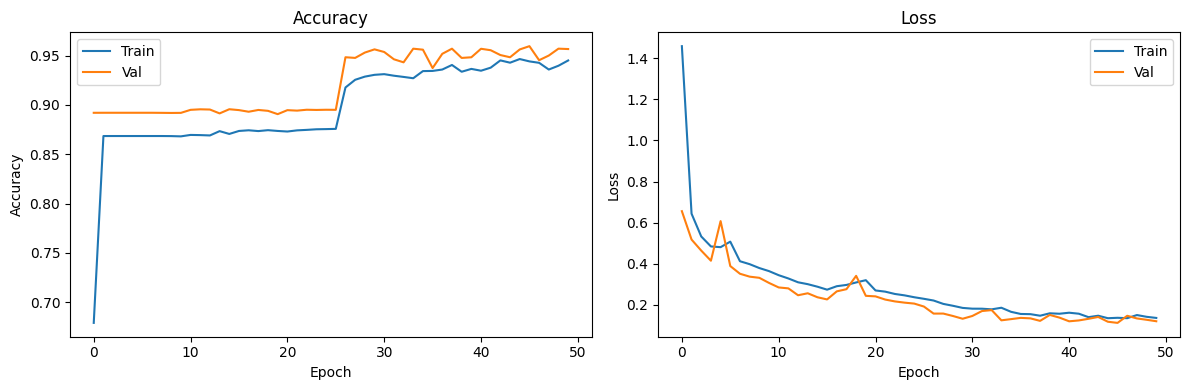

In [24]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


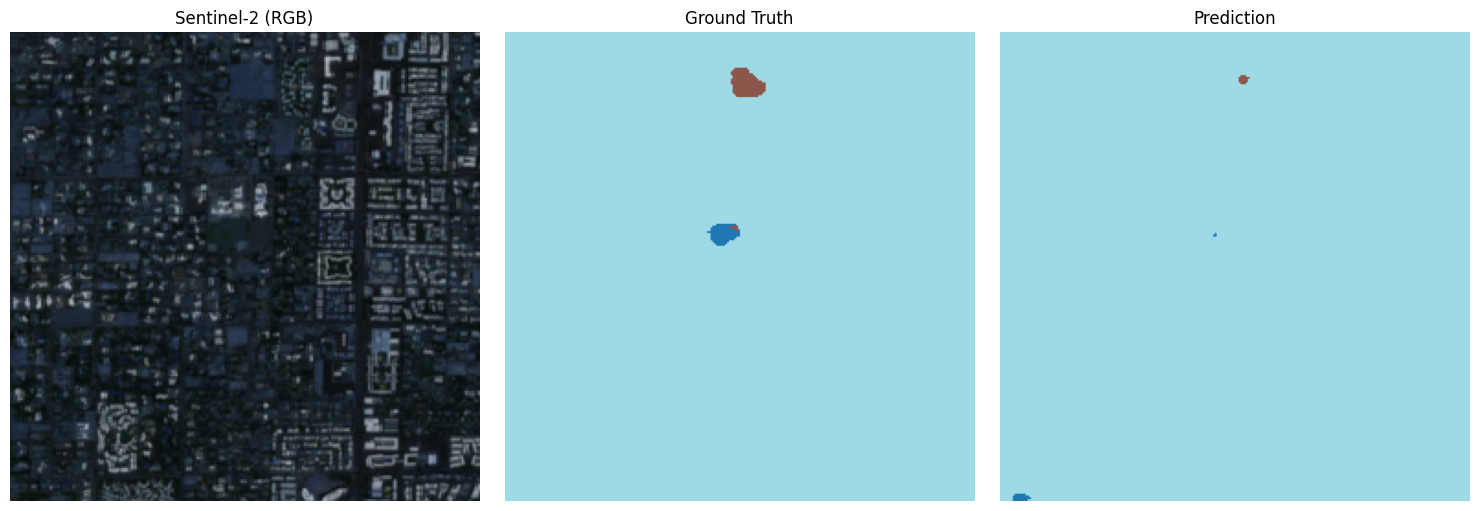

In [25]:
idx = 5  # change index for different tiles
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(X_val[idx][:, :, :3])  # RGB
ax[0].set_title("Sentinel-2 (RGB)")
ax[0].axis('off')

ax[1].imshow(np.argmax(y_val_cat[idx], axis=-1), cmap='tab20')
ax[1].set_title("Ground Truth")
ax[1].axis('off')

ax[2].imshow(np.argmax(model.predict(X_val[idx:idx+1]), axis=-1)[0], cmap='tab20')
ax[2].set_title("Prediction")
ax[2].axis('off')

plt.tight_layout()
plt.show()


In [26]:
# Sentinel-2 image shape: (bands, height, width)
full_img = np.moveaxis(s2_image[:4], 0, -1)  # (H, W, 4)
full_img = np.nan_to_num(full_img, nan=0.0)
full_img = np.clip(full_img / full_img.max(), 0, 1)


In [27]:
PATCH_SIZE = 256
H, W, C = full_img.shape

# Padding
pad_h = (PATCH_SIZE - H % PATCH_SIZE) % PATCH_SIZE
pad_w = (PATCH_SIZE - W % PATCH_SIZE) % PATCH_SIZE
padded = np.pad(full_img, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

# Extract patches
patches = []
for i in range(0, padded.shape[0], PATCH_SIZE):
    for j in range(0, padded.shape[1], PATCH_SIZE):
        patches.append(padded[i:i+PATCH_SIZE, j:j+PATCH_SIZE])
patches = np.array(patches)

# Predict
preds = model.predict(patches, verbose=1)
pred_classes = np.argmax(preds, axis=-1)

# Reconstruct full mask
recon_mask = np.zeros((padded.shape[0], padded.shape[1]), dtype=np.uint8)
k = 0
for i in range(0, padded.shape[0], PATCH_SIZE):
    for j in range(0, padded.shape[1], PATCH_SIZE):
        recon_mask[i:i+PATCH_SIZE, j:j+PATCH_SIZE] = pred_classes[k]
        k += 1

# Crop to original size
final_mask = recon_mask[:H, :W]


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


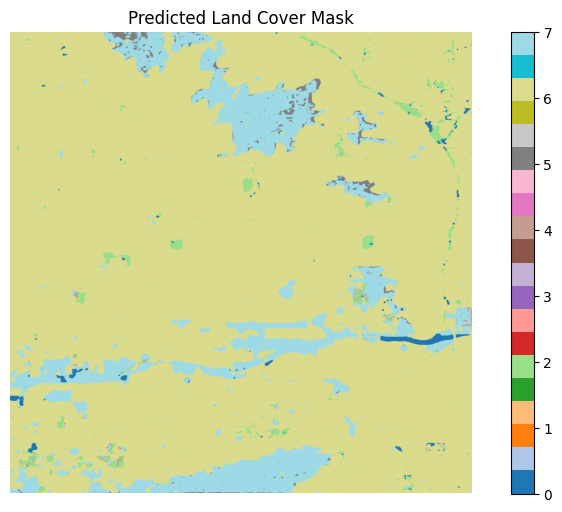

In [28]:
plt.figure(figsize=(10, 6))
plt.imshow(final_mask, cmap='tab20')
plt.title("Predicted Land Cover Mask")
plt.axis("off")
plt.colorbar()
plt.show()


In [32]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten predictions and ground truth
y_true = np.argmax(y_val, axis=-1).flatten()  # if one-hot encoded
y_pred = np.argmax(model.predict(X_val), axis=-1).flatten()

# Mask invalid pixels if any (optional)
valid_mask = (y_true >= 0) & (y_true < num_classes)
y_true = y_true[valid_mask]
y_pred = y_pred[valid_mask]



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


In [33]:
# Overall accuracy
acc = accuracy_score(y_true, y_pred)

# Per-class F1
f1 = f1_score(y_true, y_pred, average='weighted')

# IoU (Jaccard Index)
iou = jaccard_score(y_true, y_pred, average='weighted')

# Print report
print(f"Pixel-wise Accuracy: {acc * 100:.2f}%")
print(f"Weighted F1 Score: {f1 * 100:.2f}%")
print(f"Mean IoU: {iou * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Pixel-wise Accuracy: 95.95%
Weighted F1 Score: 95.50%
Mean IoU: 92.79%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      6996
           1       0.00      0.00      0.00      2169
           2       0.57      0.59      0.58      8232
           3       0.00      0.00      0.00       312
           4       0.19      0.03      0.05      3914
           5       0.60      0.14      0.22     12420
           6       0.98      0.99      0.98   1169125
           7       0.79      0.85      0.82    107529
           8       0.00      0.00      0.00        23

    accuracy                           0.96   1310720
   macro avg       0.45      0.38      0.39   1310720
weighted avg       0.95      0.96      0.96   1310720



/Users/jalpatel/Projects/UNet/myenv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jalpatel/Projects/UNet/myenv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jalpatel/Projects/UNet/myenv310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

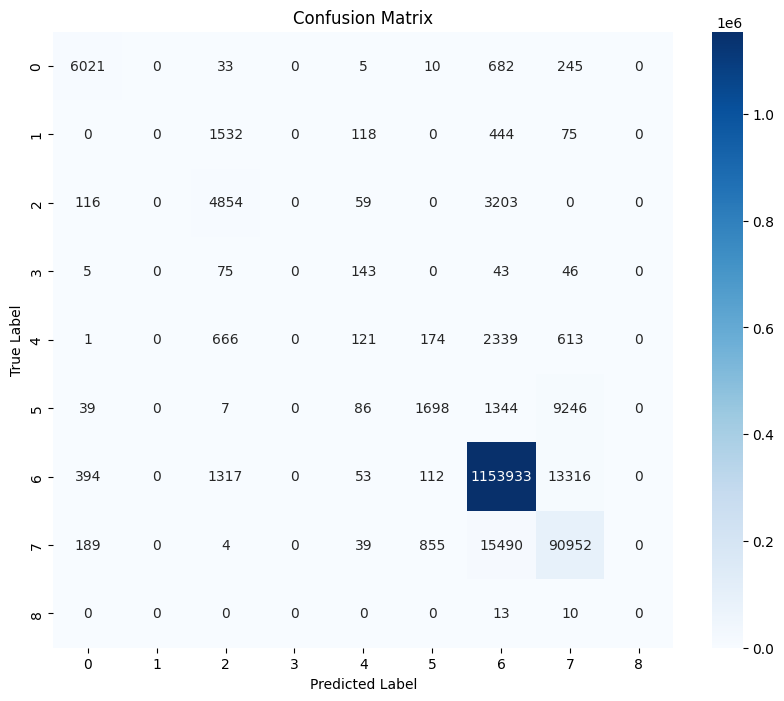

In [34]:
cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


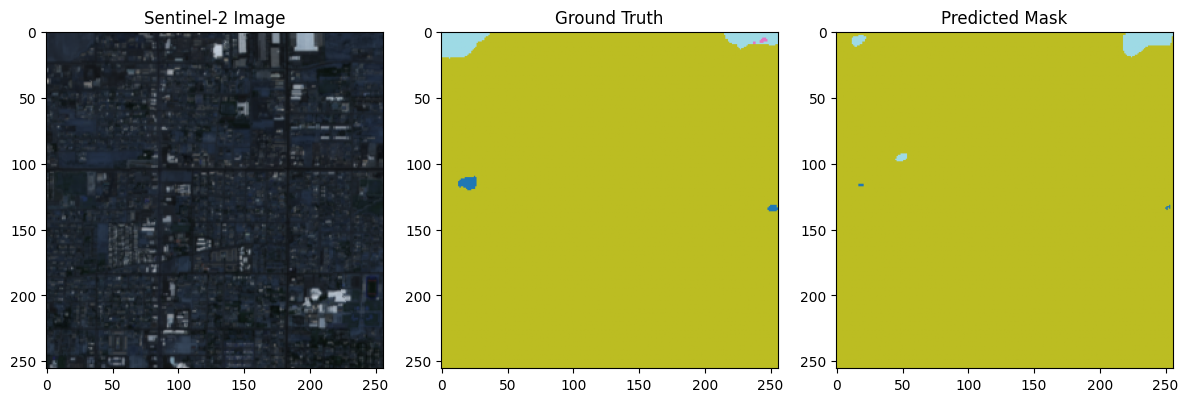

In [35]:
# Pick a sample from validation set
i = 0
sample_img = X_val[i]
true_mask = np.argmax(y_val[i], axis=-1)
pred_mask = np.argmax(model.predict(np.expand_dims(sample_img, axis=0)), axis=-1)[0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(sample_img[:, :, :3])  # RGB bands
plt.title("Sentinel-2 Image")

plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap="tab20")
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap="tab20")
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()
